In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

In [2]:
batch_1_path = '../dataset/batch-dataset/batch_1.csv'
batch_2_path = '../dataset/batch-dataset/batch_2.csv'

batch_1 = spark.read.csv(batch_1_path, header=True)
batch_2 = spark.read.csv(batch_2_path, header=True)

data = batch_1.union(batch_2)

In [3]:
data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   True|   45|        

In [4]:
# Menampilkan schema dfFrame
data.printSchema()

root
 |-- course_id: string (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [ ]:
data = data.withColumn("num_subscribers", col("num_subscribers").cast("float"))
data = data.withColumn("num_reviews", col("num_reviews").cast("float"))
data = data.withColumn("num_lectures", col("num_lectures").cast("float"))
data = data.withColumn("content_duration", col("content_duration").cast("float"))

data = data.dropna()

if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")
if "features" in data.columns:
    data = data.drop("features")

assembler = VectorAssembler(inputCols=["num_subscribers", "num_reviews", "num_lectures", "content_duration"], 
                            outputCol="features_unscaled")
data = assembler.transform(data)

data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|   features_unscaled|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|         2147.0|       23.0|        51.0|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|[2147.0,23.0,51.0...|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|         2792.0|      923.0|       274.0|        All Levels|            39.0|2017-03-09T16:34:20Z|Business Finance|[2

In [ ]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data.select("features_unscaled", "features").show()

+--------------------+--------------------+
|   features_unscaled|            features|
+--------------------+--------------------+
|[2147.0,23.0,51.0...|[0.44853612526442...|
|[2792.0,923.0,274...|[0.58328498450781...|
|[2174.0,74.0,51.0...|[0.45417677518624...|
|[2451.0,11.0,36.0...|[0.51204566512487...|
|[1276.0,45.0,26.0...|[0.26657293704583...|
|[9221.0,138.0,25....|[1.92638640478028...|
|[1540.0,178.0,26....|[0.32172595850359...|
|[2917.0,148.0,23....|[0.60939910451622...|
|[5172.0,34.0,38.0...|[1.08049782946791...|
|[827.0,14.0,15.0,...|[0.17277101797563...|
|[4284.0,93.0,76.0...|[0.89498312092817...|
|[1380.0,42.0,17.0...|[0.28829988489283...|
|[3607.0,21.0,19.0...|[0.75354904696263...|
|[4061.0,52.0,16.0...|[0.84839553083317...|
|[294.0,19.0,42.0,...|[0.06142041025977...|
|[2276.0,106.0,19....|[0.47548589711310...|
|[4919.0,79.0,16.0...|[1.02764285057089...|
|[2666.0,115.0,52....|[0.55696195153933...|
|[5354.0,24.0,23.0...|[1.11851998820015...|
|[8095.0,249.0,12....|[1.6911504

In [7]:
data.select("features").rdd.map(lambda row: len(row["features"])).distinct().collect()

[4]

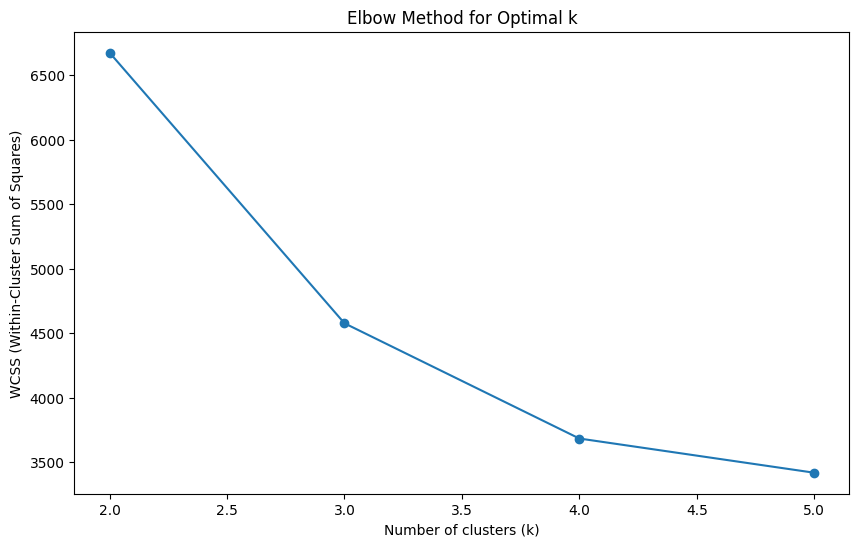

In [ ]:
wcss = []

for k in range(2, 6):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data)

    wcss.append(model.summary.trainingCost)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [ ]:
def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol="features", k=k, seed=1, maxIter=100, initSteps=10)
        model = kmeans.fit(data)
        predictions = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append((k, silhouette))
        print(f"k: {k}, Silhouette Score: {silhouette}")
    
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"\nOptimal k berdasarkan Silhouette Score adalah: {best_k}")
    
    return best_k, silhouette_scores

best_k, silhouette_scores = find_optimal_k(data, max_k=5)

kmeans = KMeans(featuresCol="features", k=best_k, seed=1, maxIter=100, initSteps=10)
model = kmeans.fit(data)

data = model.transform(data)

evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(data)
print(f"\nSilhouette Score untuk model dengan k={best_k}: {silhouette}")


data.groupBy("prediction").avg("num_subscribers", "num_reviews", "num_lectures", "content_duration").show()


k: 2, Silhouette Score: 0.9532254784480592
k: 3, Silhouette Score: 0.9454320334690631
k: 4, Silhouette Score: 0.7263509678395895
k: 5, Silhouette Score: 0.6897018749083451

Optimal k berdasarkan Silhouette Score adalah: 2

Silhouette Score untuk model dengan k=2: 0.9532254784480592
+----------+--------------------+-----------------+------------------+---------------------+
|prediction|avg(num_subscribers)| avg(num_reviews)| avg(num_lectures)|avg(content_duration)|
+----------+--------------------+-----------------+------------------+---------------------+
|         1|   17285.56603773585| 961.566037735849|191.22641509433961|    25.42452830188679|
|         0|  1219.4059151307329|39.92327475353622|30.642091727389626|    2.917038148538115|
+----------+--------------------+-----------------+------------------+---------------------+



In [13]:
model.save("spark_kmeans_model_b")

print("Model saved to spark_kmeans_model")

Model saved to spark_kmeans_model
